In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

In [2]:
table_nm = 'DLAB_INTERN_TR_IFO_TMP' 
names = ['iqr_dt','cus_no','act_no','mkt_gb','pdt_gb','iem_cd','iem_krl_anm','bnc_qty','tot_aet_amt'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE3060/{table_nm}3_3060.csv' 
df_trd = pd.read_csv(file_path) 

table_nm = 'DLAB_HT_L1_CUS_IFO_TMP' 
names = ['cus_no','sex_dit_cd','cus_age','zip_ctp_cd', 'tco_cus_grd_cd', 'ivs_icn_cd'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE3060/{table_nm}_3060.csv' 
df_cus = pd.read_csv(file_path) 

table_nm = 'DLAB_HT_L1_ACT_IFO_TMP' 
names = ['act_no','cus_no','act_opn_ym'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE3060/{table_nm}_3060.csv' 
df_act = pd.read_csv(file_path)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_act = df_act.drop('Unnamed: 0', axis=1)
df_cus = df_cus.drop('Unnamed: 0', axis=1)
df_trd = df_trd.drop('Unnamed: 0', axis=1)

In [4]:
#choose 440 customers with trd data & remove 이상한 데이터 (customers with US25459W4583)
df_cus_w = df_cus.copy()[(df_cus['cus_no'].isin(df_trd['cus_no'])) & ~(df_cus['cus_no'].isin(df_trd[(df_trd['iem_cd'] == "US25459W4583")]['cus_no']))]

In [5]:
df_bal = df_trd.copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal = df_bal.reset_index()
df_bal_kor = df_trd[df_trd['mkt_gb'] == '국내'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor = df_bal_kor.reset_index()
df_bal_ovs = df_trd[df_trd['mkt_gb'] == '해외'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs = df_bal_ovs.reset_index()

In [6]:
df_bal_tot = pd.merge(left=df_bal, 
                      right=df_bal_kor[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kr'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ov'), 
                      how='left')

In [7]:
df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']] = df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']].fillna(0)

In [8]:
df_bal_list = []
df_bal_len = []
for i in df_bal_tot['iqr_dt'].unique():
    df = df_bal_tot[df_bal_tot['iqr_dt'] == i]
    df = pd.merge(left=df_cus_w, right=df, on='cus_no', suffixes=('','')) #if how='left', customers who haven't opened an account appear
    df['ovs_ratio'] = df['tot_aet_amt_ov'] / df['tot_aet_amt']
    df_bal_list.append(df)
    df_bal_len.append(len(df))

In [9]:
df_bal_list[0].head()

,cus_no,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,iqr_dt,tot_aet_amt,tot_aet_amt_kr,tot_aet_amt_ov,ovs_ratio
0,102509999,2,35,11,09,03,20210101,8018159,7837900.0,180259.0,0.022481
1,102668963,2,56,11,04,-,20210101,11780200,11780200.0,0.0,0.000000
2,102275237,1,44,43,03,-,20210101,118127150,118127150.0,0.0,0.000000
3,102549777,2,31,-,09,-,20210101,5915140,5915140.0,0.0,0.000000
4,100235896,2,36,41,03,-,20210101,8888500,8888500.0,0.0,0.000000


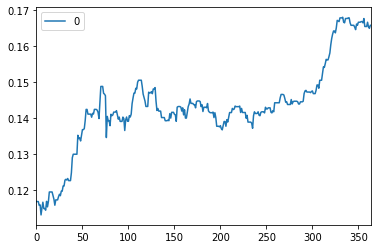

In [10]:
ovs_pct = []
for i in range(365):
    df = df_bal_list[i]
    ovs_pct.append(len(df[df['ovs_ratio'] > 0])/len(df))
pd.DataFrame(ovs_pct).plot() #고객 중 해외주식 보유자 비중 변화

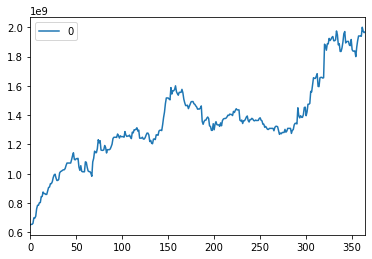

In [11]:
#해외주식 보유액 변화
ovs_tot_amt = []
for i in range(365):
    df = df_bal_list[i]
    ovs_tot_amt.append(df['tot_aet_amt_ov'].sum())
pd.DataFrame(ovs_tot_amt).plot()

In [12]:
df_bal_kor_stk = df_trd[(df_trd['mkt_gb'] == '국내') & (df_trd['pdt_gb'] == '주식')].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor_stk = df_bal_kor_stk.reset_index()
df_bal_ovs_stk = df_trd[(df_trd['mkt_gb'] == '해외') & (df_trd['pdt_gb'] == '주식')].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs_stk = df_bal_ovs_stk.reset_index()

df_bal_kor_etf = df_trd[(df_trd['mkt_gb'] == '국내') & (df_trd['pdt_gb'] == 'ETF')].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor_etf = df_bal_kor_etf.reset_index()
df_bal_ovs_etf = df_trd[(df_trd['mkt_gb'] == '해외') & (df_trd['pdt_gb'] == 'ETF')].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs_etf = df_bal_ovs_etf.reset_index()

df_bal_tot = pd.merge(left=df_bal, 
                      right=df_bal_kor_stk[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kor_stk'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs_stk[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ovs_stk'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_kor_etf[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kor_etf'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs_etf[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ovs_etf'), 
                      how='left')

In [13]:
df_bal_tot[['tot_aet_amt_kor_stk', 'tot_aet_amt_ovs_stk', 'tot_aet_amt_kor_etf', 'tot_aet_amt_ovs_etf']] = df_bal_tot[['tot_aet_amt_kor_stk', 'tot_aet_amt_ovs_stk', 'tot_aet_amt_kor_etf', 'tot_aet_amt_ovs_etf']].fillna(0)

In [14]:
df_bal_list = []
df_bal_len = []
for i in df_bal_tot['iqr_dt'].unique():
    df = df_bal_tot[df_bal_tot['iqr_dt'] == i]
    df = pd.merge(left=df_cus_w, right=df, on='cus_no', suffixes=('','')) #if how='left', customers who haven't opened an account appear
    df['kor_etf_ratio'] = df['tot_aet_amt_kor_etf'] / (df['tot_aet_amt_kor_stk']+df['tot_aet_amt_kor_etf'])
    df['ovs_etf_ratio'] = df['tot_aet_amt_ovs_etf'] / (df['tot_aet_amt_ovs_stk']+df['tot_aet_amt_ovs_etf'])
    df[['kor_etf_ratio', 'ovs_etf_ratio']] = df[['kor_etf_ratio', 'ovs_etf_ratio']].fillna(0)
    df_bal_list.append(df)
    df_bal_len.append(len(df))

In [15]:
etf_ratio_k = []
etf_ratio_o = []
for i in range(len(df_bal_list)):
#     av_k = df_bal_list[i][(df_bal_list[i]['tot_aet_amt_kor_stk'] > 0) | (df_bal_list[i]['tot_aet_amt_kor_etf'] > 0)]['kor_etf_ratio'].mean()
#     av_o = df_bal_list[i][(df_bal_list[i]['tot_aet_amt_ovs_stk'] > 0) | (df_bal_list[i]['tot_aet_amt_ovs_etf'] > 0)]['ovs_etf_ratio'].mean()
    
    av_k = (df_bal_list[i][(df_bal_list[i]['tot_aet_amt_kor_etf'] > 0)]['cus_no'].count())/(df_bal_list[i][(df_bal_list[i]['tot_aet_amt_kor_stk'] > 0) | (df_bal_list[i]['tot_aet_amt_kor_etf'] > 0)]['cus_no'].count())
    av_o = (df_bal_list[i][(df_bal_list[i]['tot_aet_amt_ovs_etf'] > 0)]['cus_no'].count())/(df_bal_list[i][(df_bal_list[i]['tot_aet_amt_ovs_stk'] > 0) | (df_bal_list[i]['tot_aet_amt_ovs_etf'] > 0)]['cus_no'].count())
    
    etf_ratio_k.append(av_k)
    etf_ratio_o.append(av_o)

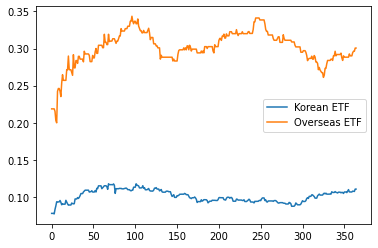

In [16]:
plt.plot(etf_ratio_k)
plt.plot(etf_ratio_o)
plt.legend(['Korean ETF', 'Overseas ETF'])
plt.show()

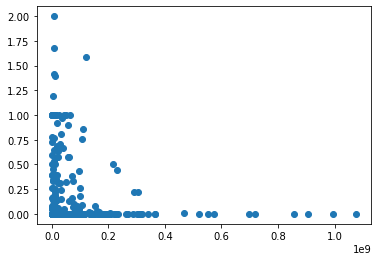

In [22]:
plt.scatter(df_bal_list[364]['tot_aet_amt'], df_bal_list[364]['kor_etf_ratio']+df_bal_list[364]['ovs_etf_ratio'])

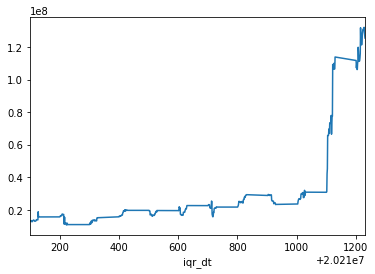

In [24]:
df_trd[df_trd['iem_krl_anm'] == '엔비디아'][['iqr_dt','bnc_qty', 'tot_aet_amt']].astype(int).groupby('iqr_dt').sum()['tot_aet_amt'].plot()